In [2]:
import pysindy as ps
import numpy as np
from CAE_NIF import CAE
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from tensorflow.keras import layers, models, optimizers

In [3]:
data = np.load('States1p0.01dt4000.npy')
data = data.reshape(4000,2000,1)
autoencoder2 = CAE(2,2000)
#optimizer = optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, name='Adam')
#autoencoder.compile(optimizer=optimizer, loss='mse')
#autoencoder.fit(data, data, epochs=300, validation_data=(data,data), batch_size=8)

In [4]:
autoencoder2.load_weights("./saved_weights/PySINDY-{}/QHOMoveLat".format(0)).expect_partial()
#outpt = autoencoder2.predict_on_batch(data)
#print(outpt.shape)
predict = autoencoder2.predict_on_batch(data)

(4000, 2)


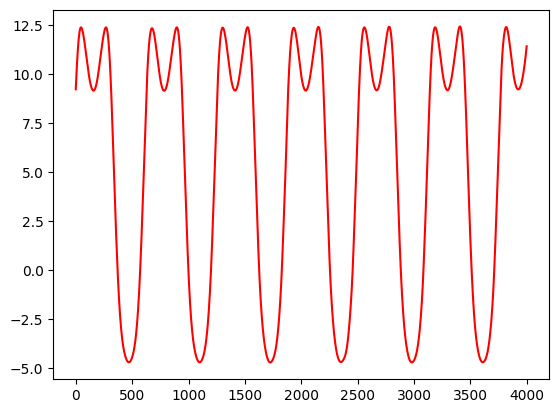

In [5]:
latent = autoencoder2.encode(data)
time_arr = np.linspace(0,40,4000)
spline1 = UnivariateSpline(time_arr, latent[:,0],s=15.6)
spline2 = UnivariateSpline(time_arr, latent[:,1],s=4.9)
#spline3 = UnivariateSpline(time_arr, latent[:,2], s=10)
#spline4 = UnivariateSpline(time_arr, latent[:,3], s=10)
l1 = spline1(time_arr)
l2 = spline2(time_arr)
#l3 = spline3(time_arr)
#l4 = spline4(time_arr)
lat = np.column_stack([l1,l2])
print(lat.shape)
plt.plot(lat[:,0], label='Smoothed Curve', color='r')
#plt.plot(latent[:], label='Normal Curve', color='b')

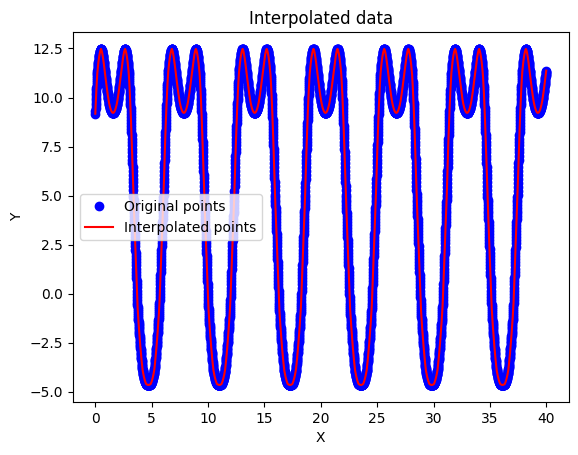

In [86]:
NT=20000
lat_long = np.zeros([NT,2])
for i in range(2):
    t = np.linspace(0, 40, 4000)  # Assuming x values are evenly spaced
    f = interp1d(t, latent[:,i], kind='cubic')
    x_new = np.linspace(0, 40, NT)  # Increase the number of points to 16000 for example
    y_new = f(x_new)
    lat_long[:,i] = y_new

# Plot original data
plt.plot(t, latent[:,0], 'bo', label='Original points')

# Plot interpolated data
plt.plot(x_new, lat_long[:,0], 'r', label='Interpolated points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated data')
#plt.ylim(10,11.5)
plt.show()

In [88]:
noise_mean = 0
noise_std = 0.001

# Generate Gaussian noise
noise = np.random.normal(noise_mean, noise_std, lat_long.shape)

# Add the noise to the original array
noisy_array = lat_long + noise

# Print the original and noisy arrays
print("Original Array:\n", lat_long)
print("Noisy Array:\n", noisy_array)

Original Array:
 [[ 9.17302513 10.92550087]
 [ 9.20233287 10.91227737]
 [ 9.23151228 10.89896116]
 ...
 [11.35300557 -0.26189367]
 [11.36249071 -0.23738665]
 [11.37196732 -0.2128081 ]]
Noisy Array:
 [[ 9.1719762  10.92667393]
 [ 9.2038387  10.91402323]
 [ 9.2321391  10.89757416]
 ...
 [11.35235834 -0.25990399]
 [11.3614193  -0.23799007]
 [11.37233302 -0.21399639]]


In [90]:
def finite_difff(points, time):
    t = time
    X=points
    finite_diff = np.zeros_like(X)
    for i in range(finite_diff.shape[1]):
        for j in range(finite_diff.shape[0]):
            if j < 4:
                finite_diff[j,i] = (-25/12*X[j,i] + 4*X[j+1,i] -3*X[j+2,i] + 4/3*X[j+3,i] - 1/4*X[j+4,i])/(t[1]-t[0])
            elif j > finite_diff.shape[0]-4:
                finite_diff[j,i] = (25/12*X[j,i] - 4*X[j-1,i] +3*X[j-2,i] - 4/3*X[j-3,i] + 1/4*X[j-4,i])/(t[1]-t[0])
            else:
                finite_diff[j,i] = (-1/50*X[j-3,i] + 3/20*X[j-2,i] -3/4*X[j-1,i] + 3/4*X[j+1,i] - 3/20*X[j+2,i] + 1/50*X[j+3,i])/(t[1]-t[0])
    return finite_diff

first_diff = finite_difff(lat_long, x_new)
second_diff = finite_difff(first_diff,x_new)

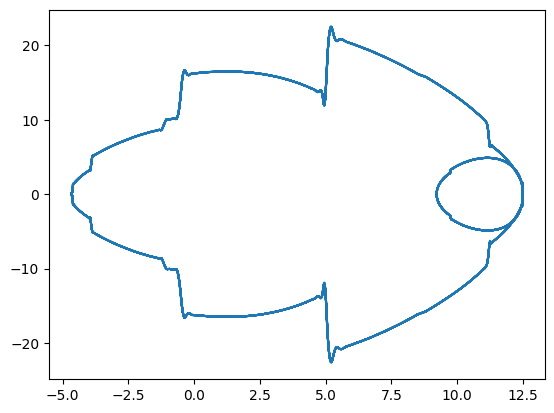

In [92]:
X = noisy_array
deriv = np.concatenate(([np.zeros(2)], np.diff(lat_long, axis=0) / (t[1]-t[0])))
time = 160
plt.plot(X[time:-time,0], first_diff[time:-time,0])
#plt.plot(finite_diff[time:-time])
#plt.plot(X[2000:-2000,0], deriv[2000:-2000,0])

0
1


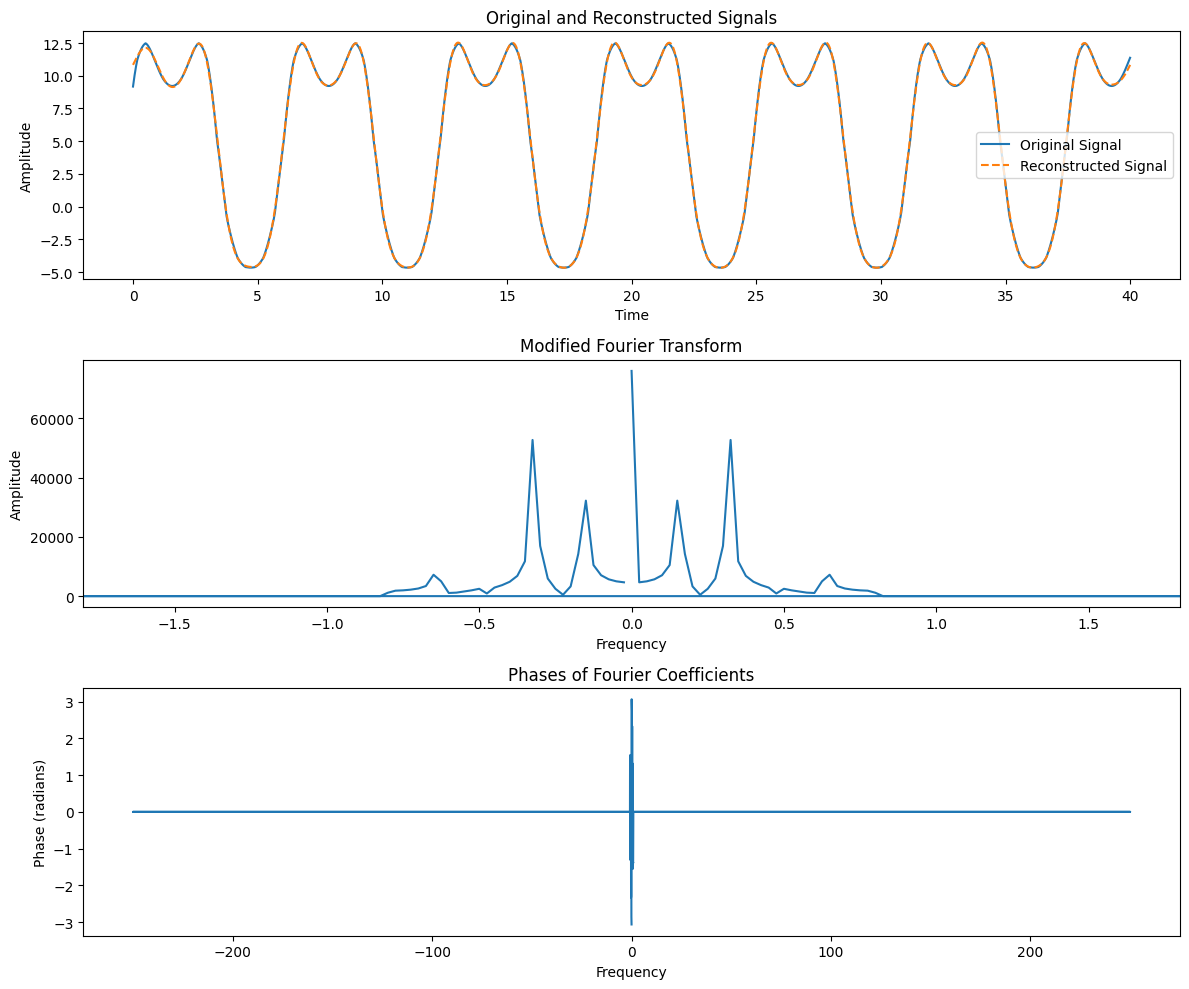

In [120]:
eq = []
X=lat_long
finite = None
for i in range(X.shape[1]):
    print(i)
    # Generate a sample signal
    t = np.linspace(0, 40, X.shape[0], endpoint=False)  # time points from 0 to 40 (exclusive) with 4000 samples
    signal = X[:,i]  # Example signal (replace with your data)
    # Compute Fourier transform
    fourier_transform = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), t[1] - t[0])  # compute frequency axis   
    # Example: Zeroing out frequencies above 'num' Hz
    num = 0.8
    fourier_transform[np.abs(freqs) > num] = 0
    
    # Extract amplitudes and phases
    amplitudes = np.abs(fourier_transform)
    phases = np.angle(fourier_transform)
    
    # Construct reconstructed signal
    t_large = np.linspace(0,40,X.shape[0])
    waveform = np.zeros_like(t_large)
    for j in range(len(freqs)):
        amplitude = amplitudes[j]
        phase = phases[j]
        freq = freqs[j]
        waveform += amplitude * np.cos(2 * np.pi * freq * t_large + phase)/X.shape[0]
    if i == 0:
        first_one = waveform
    eq.append(waveform)

finite = np.array(eq).T
# Plotting
plt.figure(figsize=(12, 10))

# Original and Reconstructed signal plot
plt.subplot(3, 1, 1)
plt.plot(t, X[:,0], label='Original Signal')
plt.plot(t_large, first_one, label='Reconstructed Signal', linestyle='--')
plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Fourier transform plot
plt.subplot(3, 1, 2)
plt.plot(freqs, np.abs(fourier_transform))
plt.title('Modified Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(-num-1, num+1)

# Phase plot
plt.subplot(3, 1, 3)
plt.plot(freqs, phases)
plt.title('Phases of Fourier Coefficients')
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.tight_layout()
plt.show()

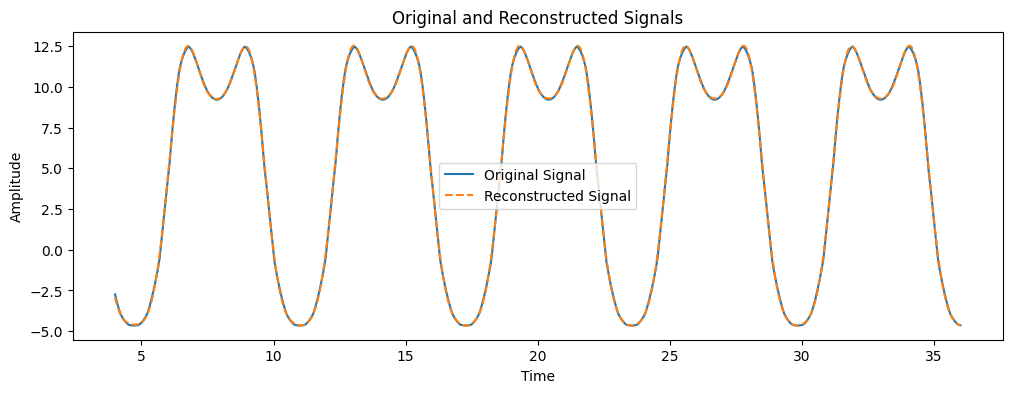

In [122]:
num=2000
plt.figure(figsize=(12, 4))
plt.plot(t[num:-num], X[num:-num,0], label='Original Signal')
plt.plot(t_large[num:-num], first_one[num:-num], label='Reconstructed Signal', linestyle='--')
plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [205]:
ti = t
time=400
start=time
end = -time
first_deriv = finite_difff(finite,ti)
second_deriv = finite_difff(first_deriv,ti)
third_deriv = finite_difff(second_deriv,ti)
fourth_deriv = finite_difff(third_deriv,ti)
fifth_deriv = finite_difff(fourth_deriv,ti)
sixth_deriv = finite_difff(fifth_deriv,ti)
seventh_deriv = finite_difff(sixth_deriv,ti)
eighth_deriv = finite_difff(seventh_deriv,ti)
seventh_deriv = finite_difff(sixth_deriv,ti)


deriv=np.concatenate(([np.zeros(2)], np.diff(finite, axis=0) / (ti[1]-ti[0])))
deriv2 = np.concatenate(([np.zeros(2)], np.diff(deriv, axis=0) / (ti[1]-ti[0])))
deriv3 = np.concatenate(([np.zeros(2)], np.diff(deriv2, axis=0) / (ti[1]-ti[0])))
deriv4 = np.concatenate(([np.zeros(2)], np.diff(deriv3, axis=0) / (ti[1]-ti[0])))
deriv5 = np.concatenate(([np.zeros(2)], np.diff(deriv4, axis=0) / (ti[1]-ti[0])))
deriv6 = np.concatenate(([np.zeros(2)], np.diff(deriv5, axis=0) / (ti[1]-ti[0])))
deriv7 = np.concatenate(([np.zeros(2)], np.diff(deriv6, axis=0) / (ti[1]-ti[0])))
deriv8 = np.concatenate(([np.zeros(2)], np.diff(deriv7, axis=0) / (ti[1]-ti[0])))
deriv9 = np.concatenate(([np.zeros(2)], np.diff(deriv8, axis=0) / (ti[1]-ti[0])))
deriv10 = np.concatenate(([np.zeros(2)], np.diff(deriv9, axis=0) / (ti[1]-ti[0])))
deriv11 = np.concatenate(([np.zeros(2)], np.diff(deriv10, axis=0) / (ti[1]-ti[0])))

X_ = np.column_stack([finite,first_deriv,second_deriv,third_deriv,fourth_deriv,fifth_deriv,sixth_deriv,seventh_deriv])

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=10, thresholder="l1", max_iter=50, normalize_columns=True, tol=1e-12
)
model = ps.SINDy(differentiation_method=ps.FiniteDifference(order=4), feature_library=ps.PolynomialLibrary(degree=1), 
         optimizer=ps.STLSQ(threshold=0.01,normalize_columns=False))

#model = ps.SINDy(feature_library=ode_lib, optimizer=ps.STLSQ(threshold=0.05,normalize_columns=False))
model.fit(X_[start:end], t=ti[1]-ti[0], ensemble=True, replace=False,n_models=10,quiet=True)
model.print()

(x0)' = 0.980 x2
(x1)' = 0.980 x3
(x2)' = 0.980 x4
(x3)' = 0.980 x5
(x4)' = 0.980 x6
(x5)' = 0.980 x7
(x6)' = 0.980 x8
(x7)' = 0.980 x9
(x8)' = 0.980 x10
(x9)' = 0.980 x11
(x10)' = 590.853 1 + -56.292 x0 + -74.476 x1 + 1.131 x2 + 2.533 x3 + -33.578 x4 + -16.842 x5 + 0.358 x6 + 0.762 x7 + -3.848 x8 + -0.575 x9 + 0.023 x10 + 0.032 x11 + 0.877 x12
(x11)' = 569.517 1 + -34.144 x0 + -98.073 x1 + -2.472 x2 + -5.314 x3 + -6.464 x4 + -38.755 x5 + -0.819 x6 + -1.573 x7 + -0.240 x8 + -3.672 x9 + -0.056 x10 + -0.064 x11 + 0.880 x13
(x12)' = -6123.889 1 + 499.766 x0 + 905.136 x1 + -142.756 x2 + -277.498 x3 + 193.578 x4 + 233.379 x5 + -55.926 x6 + -79.590 x7 + 16.820 x8 + 1.814 x9 + -5.140 x10 + -3.458 x11 + 0.330 x12 + -0.390 x13 + 0.874 x14
(x13)' = 2778.894 1 + -229.695 x0 + -423.928 x1 + -1.272 x2 + -24.944 x3 + -74.232 x4 + -120.970 x5 + 1.172 x6 + -15.876 x7 + -4.795 x8 + -2.301 x9 + 0.083 x10 + -2.597 x11 + -0.043 x12 + 0.132 x13 + 0.871 x15
(x14)' = 2830280576.747 1 + -269240215.687 x0 + -3

In [ ]:
start = 400
end = -1
x_simulated = model.simulate(X_[start], ti[start:end], integrator_kws={'atol': 1e-12, 'method': 'RK45', 'rtol': 1e-12}, interpolator_kws={})

print(len(x_simulated))
plt.plot(ti[start:end],x_simulated[:,0], label='Simulated')
plt.plot(ti[start:end],X_[start:end,0], alpha=0.5, label='Actual')
plt.legend()
plt.show()

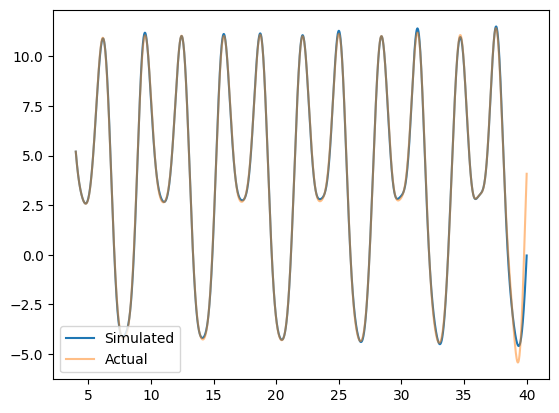

In [183]:
plt.plot(ti[start:end],x_simulated[:,1], label='Simulated')
plt.plot(ti[start:end],X_[start:end,1], alpha=0.5, label='Actual')
plt.legend()